In [ ]:
!pip install pykalman
!pip install pykrige



In [ ]:
# Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Masking, LSTM, Dense

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.linear_model import LassoCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import STL

from pykalman import KalmanFilter

from statsmodels.tsa.arima.model import ARIMA

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

import xarray as xr

from scipy.linalg import svd
from scipy.stats import boxcox
from scipy.stats import chi2_contingency
from scipy.sparse.linalg import svds
from scipy.interpolate import CubicSpline

from keras.models import Sequential
from keras.layers import LSTM, Dense

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.impute import KNNImputer
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, DotProduct
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression


from pykrige.ok import OrdinaryKriging

import warnings




# Preprocessing

In [ ]:
# Load single dataset
df1 = pd.read_csv("USCASJpillow_qa_table.csv")

# No merge takes place, but we assign to df_merged to avoid rewriting downstream code
df_merged = df1.copy()

# Complete list of selected stations with their lat/lon
station_data = [
    ['AGP', 37.7267, -119.1419], ['BCB', 37.0667, -118.7667],
    ['BGP', 37.1283, -118.475], ['BSH', 37.1003, -118.5558],
    ['CHM', 37.4081, -119.48], ['DAN', 37.9, -119.3],
    ['DPO', 37.63, -119.0933], ['FLV', 37.7944, -119.3475],
    ['GEM', 37.78, -119.178], ['GRM', 37.555, -119.2381],
    ['GRV', 37.4627, -119.2957], ['HNT', 37.228, -119.221],
    ['KSP', 37.3, -119.1], ['KUB', 37, -119.25], ['KUP', 37.1, -119.2],
    ['LLE', 38.283, -119.617], ['MHP', 37.61, -119.033],
    ['PSR', 37.4031, -119.52], ['RCK', 37.455, -118.743],
    ['SLK', 37.176, -118.562], ['STL', 36.927, -118.574],
    ['STR', 37.637, -119.55], ['SWM', 37.162, -118.562], ['TMR', 37.165, -119.2],
    ['TNY', 37.838, -119.448], ['TUM', 37.8765, -119.3481],
    ['UBC', 37.183, -118.937], ['VLC', 37.388, -118.903],
    ['WWC', 37.03, -118.918]
]

# Create DataFrame of station metadata
latlon_df = pd.DataFrame(station_data, columns=['station', 'lat', 'lon'])

# Define list of target station names
target_stations = latlon_df["station"].tolist()

# Keep only columns in df_merged that match the target stations
valid_stations = [col for col in df_merged.columns if col.split('_')[0] in target_stations]

# Subset DataFrame to include time and valid station columns
df_filtered = df_merged[["time"] + valid_stations].copy()

# Convert "time" to datetime format
df_filtered["time"] = pd.to_datetime(df_filtered["time"], errors="coerce")

# Set datetime as index and drop original time column
df_filtered.set_index(pd.DatetimeIndex(df_filtered["time"]), inplace=True)
df_filtered.drop("time", axis=1, inplace=True)


In [ ]:
# Load or create the 'patched_df' DataFrame

patched_df = df_filtered

#check for negatives
(patched_df < 0).sum()

,0
AGP,0
BCB,0
BGP,0
BSH,0
CHM,0
DAN,0
DPO,0
FLV,0
GEM,0
GRM,0


<Axes: >

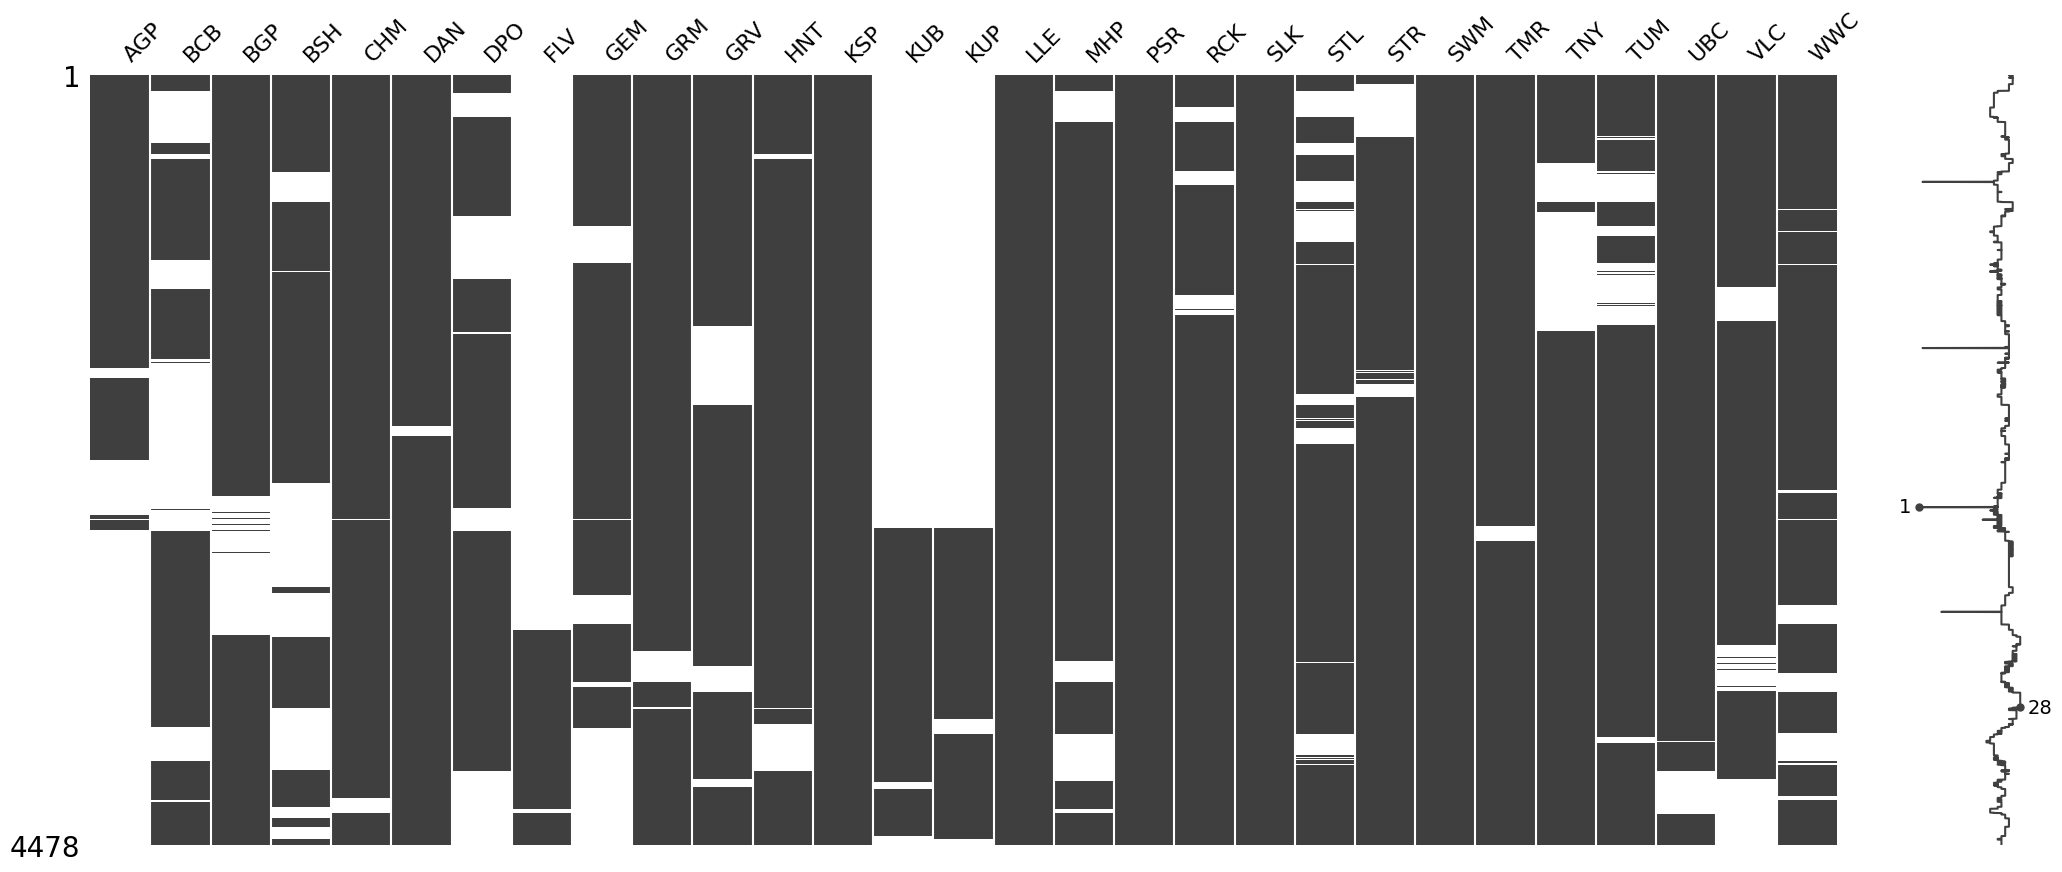

In [ ]:

# Visual inspection of missingness
msno.matrix(df_filtered)


The missingness in the dataset appears to be structured rather than Missing Completely At Random (MCAR). This is evident from the large contiguous blocks of missing values in specific columns, as shown by the white gaps. These patterns suggest that missing data are not randomly distributed but may be dependent on time, station characteristics, or other external variables.

The density plot on the right further supports this: it reveals a heterogeneous row-wise pattern where some time periods have many stations missing simultaneously, while others have very few. This clustering of missingness across time strongly indicates the presence of Missing at Random (MAR) or even Missing Not at Random (MNAR) mechanisms.

Possible underlying causes include sensor outages, elevation-driven measurement constraints, seasonal accessibility issues, or instrument-specific failures. Therefore, any imputation strategy should be selected with the assumption that missingness depends on observable or latent variables—not purely random noise.

In [ ]:
# MCAR Test


def mcar_test(df):
    # Create a boolean DataFrame indicating missingness
    missing_df = df.isna().astype(int)
    p_values = {}

    for col in missing_df.columns:
        observed = missing_df[col]
        for other_col in df.columns:
            if col != other_col and df[other_col].dtype in [float, int]:
                other_data = pd.qcut(df[other_col], q=4, duplicates='drop')
                contingency_table = pd.crosstab(observed, other_data)
                if contingency_table.shape[0] > 1:
                    chi2, p, _, _ = chi2_contingency(contingency_table)
                    p_values[f'{col} vs {other_col}'] = p

    return pd.Series(p_values).sort_values()

# Usage example:
p_vals = mcar_test(df_filtered)
print(p_vals)

MHP vs GEM    6.172670e-99
MHP vs LLE    8.096204e-87
GRM vs GEM    5.307482e-67
AGP vs STR    2.020115e-62
KUP vs KUB    4.646038e-60
                  ...     
PSR vs RCK    1.000000e+00
PSR vs HNT    1.000000e+00
PSR vs GRV    1.000000e+00
HNT vs KUP    1.000000e+00
BSH vs KUP    1.000000e+00
Length: 697, dtype: float64


The results strongly suggest that the missingness in this dataset does not follow a Missing Completely At Random (MCAR) mechanism. This conclusion is based on the presence of numerous extremely small p-values from pairwise station comparisons (e.g., MHP vs GEM = 6.17e-99, GRM vs GEM = 5.31e-67). These values indicate statistically significant dependencies in the patterns of missingness across stations.

Under the MCAR assumption, such p-values should be uniformly high, which implies no systematic relationship between missing data in one station and observed data in others. Instead, the consistent detection of low p-values reveals that missingness is not independent, and is likely influenced by observable factors such as sensor locations, shared maintenance schedules, or environmental conditions.

This strongly supports a Missing At Random (MAR) mechanism, where missingness is systematically related to observed variables. In some cases, the pattern may also align with Missing Not At Random (MNAR) behavior, where the likelihood of missing data depends on values that are themselves unobserved. Either way, MCAR can be confidently rejected, and imputation strategies must be designed accordingly—assuming structured dependencies in the missingness process.



In [ ]:
# Clean the filtered data
df_filtered.drop(columns=["Unnamed: 0"], errors="ignore", inplace=True)
df_filtered = df_filtered.drop_duplicates().clip(lower=0)

# Now you have a clean DataFrame ready for analysis/imputation
print(df_filtered.head())



              AGP     BCB  BGP  BSH  CHM  DAN  DPO  FLV  GEM  GRM  ...  SLK  \
time                                                               ...        
2012-10-01    NaN  97.790  0.0  0.0  0.0  0.0  0.0  NaN  0.0  0.0  ...  0.0   
2012-10-02    NaN  97.536  0.0  0.0  0.0  0.0  0.0  NaN  0.0  0.0  ...  0.0   
2012-10-03  2.032  97.028  0.0  0.0  0.0  0.0  0.0  NaN  0.0  0.0  ...  0.0   
2012-10-04  0.000  96.520  0.0  0.0  0.0  0.0  0.0  NaN  0.0  0.0  ...  0.0   
2012-10-05  0.000  97.790  0.0  0.0  0.0  0.0  0.0  NaN  0.0  0.0  ...  0.0   

            STL  STR  SWM  TMR  TNY  TUM  UBC  VLC  WWC  
time                                                     
2012-10-01  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2012-10-02  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2012-10-03  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2012-10-04  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2012-10-05  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 29 columns]


In [ ]:
# Final Cleaning

# Check missing data
missing_percent = df_filtered.isna().mean() * 100
print("Missing data (%):\n", missing_percent)

# Check zeros
zero_counts = (df_filtered == 0).sum()
print("\nZero counts:\n", zero_counts)

# Handle duplicate timestamps
if df_filtered.index.duplicated().any():
    print("\nDuplicate timestamps detected. Aggregating...")
    df_filtered = df_filtered.groupby(df_filtered.index).mean()

Missing data (%):
 AGP    51.432169
BCB    39.723009
BGP    14.888259
BSH    30.626377
CHM     2.706956
DAN     1.605288
DPO    25.747561
FLV    72.049103
GEM    24.394082
GRM     6.169342
GRV    16.902738
HNT     7.333963
KSP     0.094429
KUB    61.976708
KUP    62.732137
LLE     0.000000
MHP    15.801070
PSR     0.125905
RCK     6.547057
SLK     0.125905
STL    20.428077
STR     8.372679
SWM     0.094429
TMR     2.801385
TNY    18.633931
TUM    13.471829
UBC     7.900535
VLC    20.144791
WWC    11.614731
dtype: float64

Zero counts:
 AGP     299
BCB     357
BGP     879
BSH     451
CHM     878
DAN     683
DPO    1009
FLV     155
GEM     394
GRM     961
GRV     957
HNT    1000
KSP     818
KUB     386
KUP     575
LLE     276
MHP     504
PSR    1267
RCK     986
SLK     969
STL     800
STR     714
SWM     940
TMR    1084
TNY     668
TUM     867
UBC     670
VLC     492
WWC     948
dtype: int64


In [ ]:
# Drop high-missingness stations (>60%)
high_missing = missing_percent[missing_percent > 60].index.tolist()
df_filtered.drop(columns=high_missing, inplace=True)
print(f"Stations dropped due to high missingness: {high_missing}")


Stations dropped due to high missingness: ['FLV', 'KUB', 'KUP']


In [ ]:
# Step 1: Define ADF test function

def adf_test(series):
    try:
        result = adfuller(series.dropna())
        return result[1]  # Return p-value
    except Exception as e:
        print(f"ADF test failed for {series.name}: {e}")
        return None
# Step 2: Run ADF on all columns (only skip if not enough data to run)
adf_results = {}
non_stationary = []

for col in df_filtered.columns:
    p = adf_test(df_filtered[col])
    if p is not None:
        adf_results[col] = p
        if p > 0.05:
            non_stationary.append(col)

print("Non-stationary columns:", non_stationary)

Non-stationary columns: []


In [ ]:

# Calculate columns with high zero counts (e.g., more than 50% zeros)
zero_percent = (df_filtered == 0).mean() * 100
high_zero_cols = zero_percent[zero_percent > 60].index.tolist()

# Check if high_zero_cols is empty; handle gracefully if no columns meet the criteria
if high_zero_cols:
    df_filtered[high_zero_cols].hist(bins=50, figsize=(12, 8))
    plt.show()
else:
    print("No columns found with more than 50% zero values.")

# Apply log transformation to reduce skewness (if zeros are valid)
df_log = df_filtered[high_zero_cols].apply(lambda x: np.log1p(x) if x.min() >= 0 else x)

No columns found with more than 50% zero values.


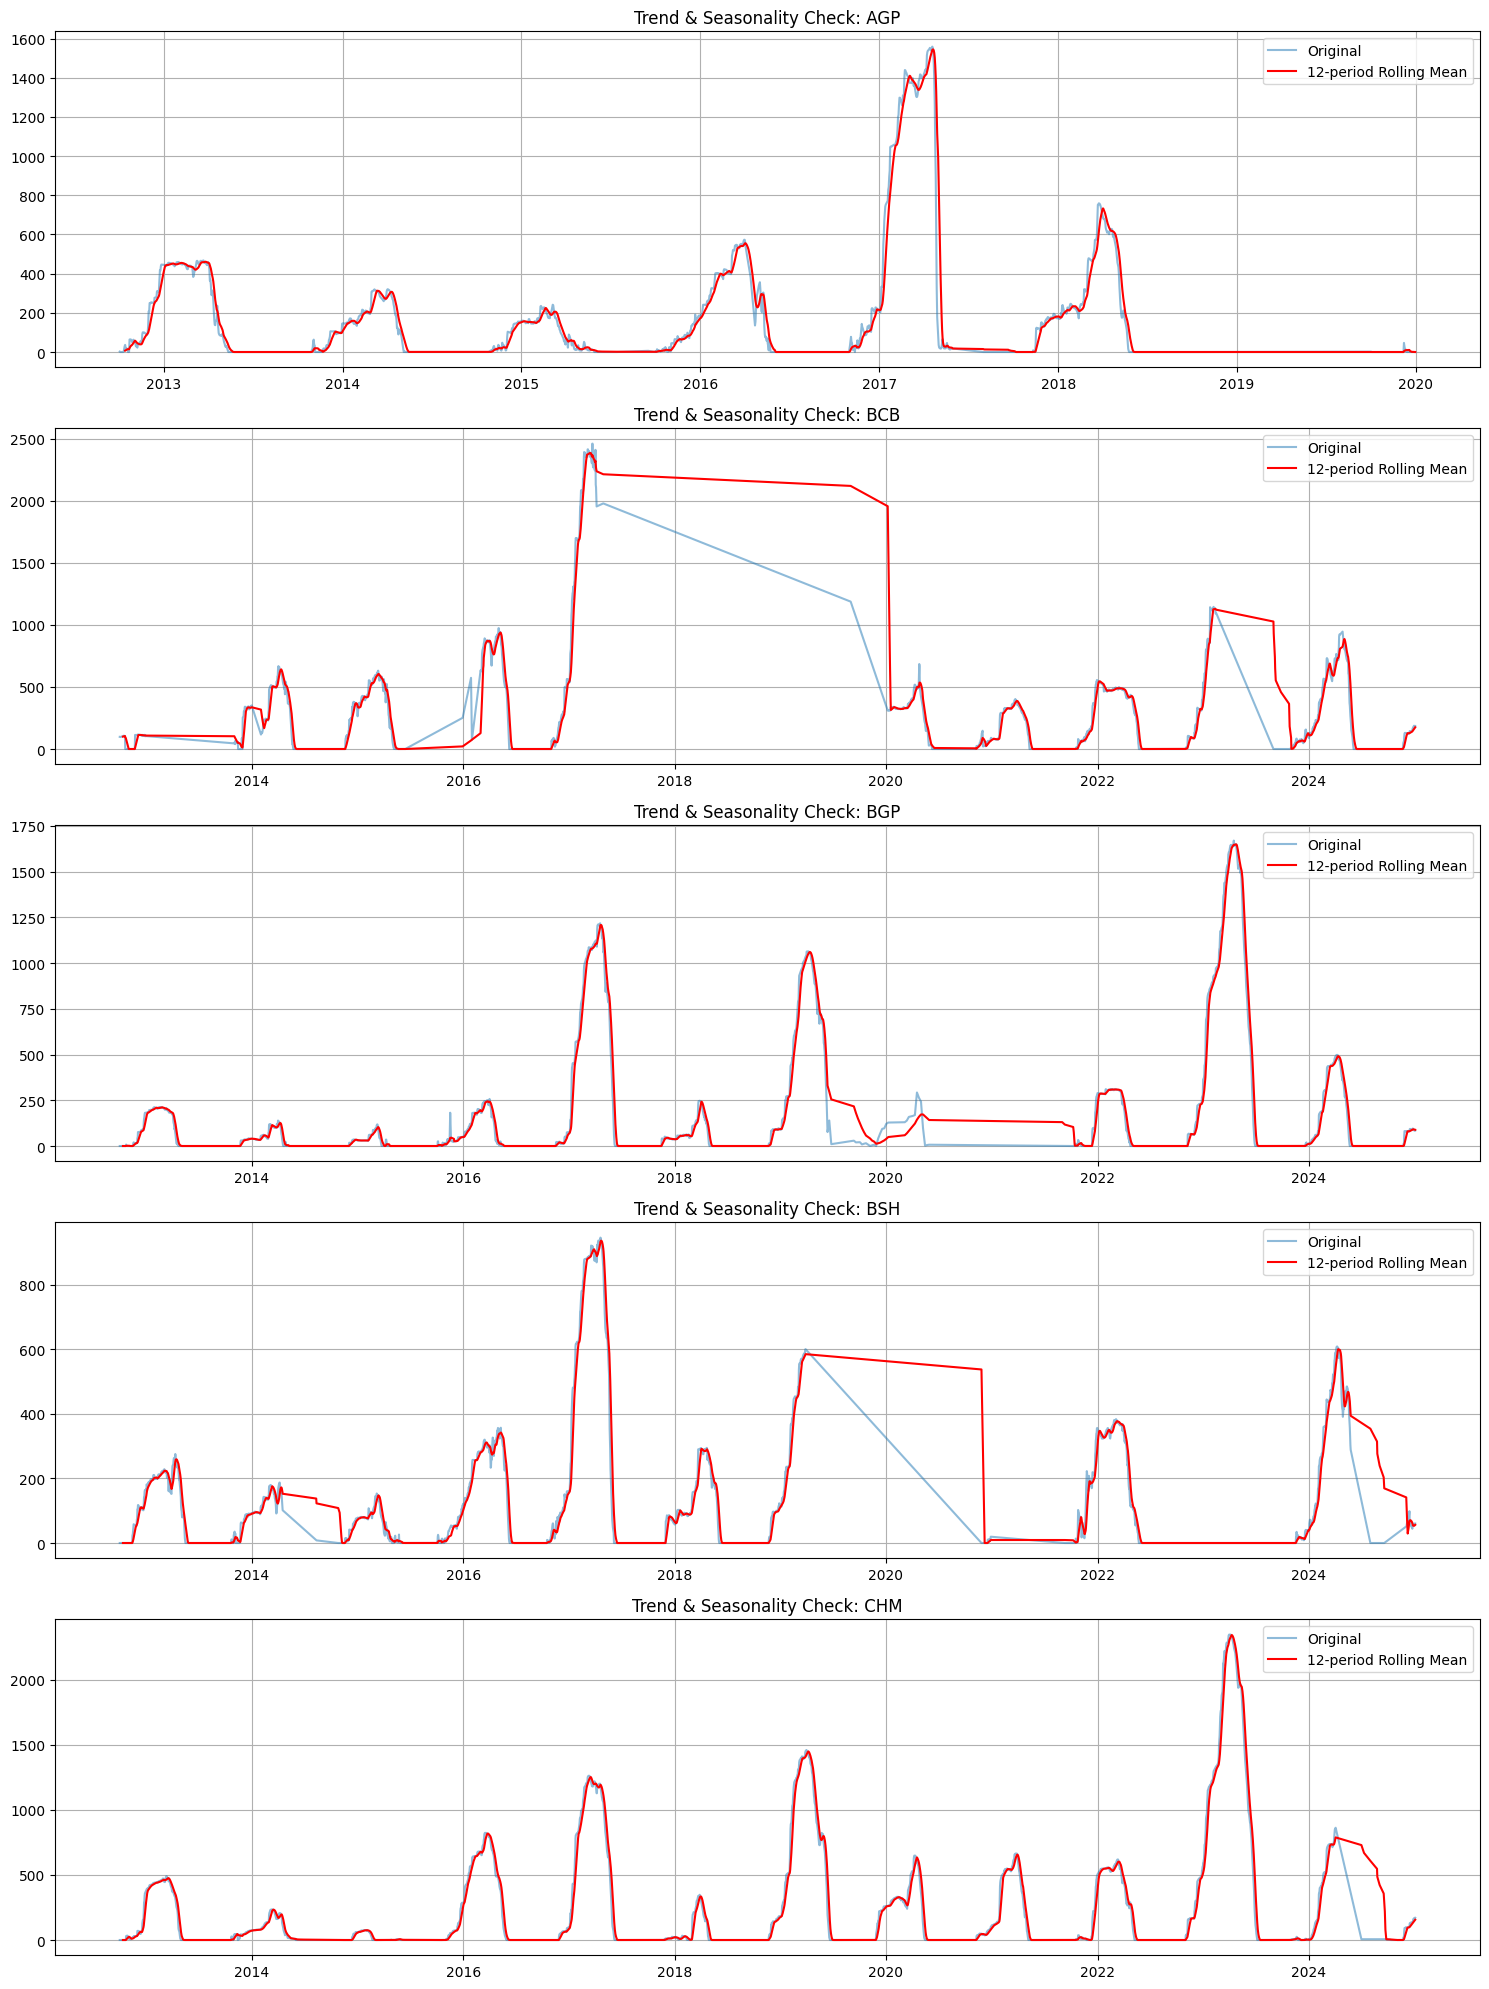

In [ ]:
# Visualize Seasonality & Trends

def plot_seasonality_and_trend(df, columns, window=12):
    n = len(columns)
    plt.figure(figsize=(15, 4 * n))

    for i, col in enumerate(columns):
        series = df[col].dropna()
        plt.subplot(n, 1, i+1)
        plt.plot(series.index, series, label="Original", alpha=0.5)
        plt.plot(series.rolling(window).mean(), label=f"{window}-period Rolling Mean", color='red')
        plt.title(f"Trend & Seasonality Check: {col}")
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage
plot_seasonality_and_trend(df_filtered, df_filtered.columns[:5])


The time series visualizations for stations AGP, DAN, DPO, GEM, and GRM clearly illustrate strong seasonality in snow water equivalent (SWE), marked by distinct annual peaks during winter months followed by sharp declines through spring. These patterns are consistent with typical snow accumulation and melt cycles in mountainous or snow-dominated regions.

The 12-period rolling mean, which is in red, helps smooth short-term fluctuations, revealing broader seasonal structure and subtle long-term shifts. In particular, GEM and DAN exhibit notable increases in baseline SWE ipost-2020. This suggests either a trend toward more persistent winter accumulation or changes in local snowpack dynamics. GEM shows increasingly pronounced peak amplitudes, which may be indicative of more intense snowfall events or enhanced snow retention.

Some rolling means flatten or truncate abruptly (e.g., in FLV or MHP, not shown here), which may reflect systematic data gaps—possibly due to sensor failures, seasonal inaccessibility, or transmission loss during specific periods. These anomalies highlight the importance of addressing missingness in the data preprocessing pipeline.

Overall, the plots confirm a combination of well-preserved seasonal structure and potentially rising baseline trends in several locations, which could point to climate-driven shifts in precipitation regimes or improvements in station instrumentation and data continuity.

In [ ]:
# === KPSS Test Function ===
from statsmodels.tsa.stattools import kpss
import numpy as np

# === KPSS Test Function ===
def kpss_test(series, regression='c'):
    try:
        stat, p_value, _, _ = kpss(series.dropna(), regression=regression, nlags='auto')
        return p_value
    except Exception as e:
        print(f"{series.name}: KPSS failed → {e}")
        return None

# === Step 1: Track zeros for restoration later ===
zero_mask = df_filtered == 0

# === Step 2: Initial KPSS test on ADF-screened data ===
print("\nRunning KPSS test on ADF-tested series...")
kpss_results = {col: kpss_test(df_filtered[col]) for col in df_filtered.columns}
non_stationary_kpss = [col for col, p in kpss_results.items() if p is not None and p < 0.05]
print("\n Non-stationary (KPSS):", non_stationary_kpss)

# === Step 3: Apply log + differencing (with zero protection) ===
df_kpss_transformed = df_filtered.copy()

for col in non_stationary_kpss:
    series = df_filtered[col]
    log_series = series.copy()
    log_series[log_series > 0] = np.log(log_series[log_series > 0])  # safe log

    diffed = log_series.diff()
    diffed[zero_mask[col]] = 0  # protect real zeros

    df_kpss_transformed[col] = diffed
    print(f"{col}: log + diff applied")

# === Step 4: Re-test KPSS after first differencing ===
kpss_post = {col: kpss_test(df_kpss_transformed[col]) for col in non_stationary_kpss}
still_nonstationary = [col for col, p in kpss_post.items() if p is not None and p < 0.05]
now_stationary = list(set(non_stationary_kpss) - set(still_nonstationary))

print("\n Now stationary after 1st transform:", now_stationary)
print(" Still non-stationary after 1st transform:", still_nonstationary)

# === Step 5: Apply second differencing to stubborn columns ===
for col in still_nonstationary:
    print(f"{col}: applying second differencing...")
    second_diff = df_kpss_transformed[col].diff()
    second_diff[zero_mask[col]] = 0
    df_kpss_transformed[col] = second_diff

# === Step 6: Final KPSS test ===
kpss_final = {col: kpss_test(df_kpss_transformed[col]) for col in still_nonstationary}
still_nonstationary_final = [col for col, p in kpss_final.items() if p is not None and p < 0.05]
now_stationary_final = list(set(still_nonstationary) - set(still_nonstationary_final))

# === Step 7: Report ===
print("\n=== Final KPSS Stationarity Summary ===")
print(f"Initially non-stationary (KPSS): {len(non_stationary_kpss)}")
print(f"→ Now stationary after log + diff: {len(now_stationary)}")
print(f"→ Now stationary after 2nd diff: {len(now_stationary_final)}")
print(f"→ Still non-stationary after both: {len(still_nonstationary_final)}")

if still_nonstationary_final:
    print(" Columns still non-stationary:", still_nonstationary_final)
else:
    print("All KPSS-tested columns are now stationary.")



Running KPSS test on ADF-tested series...

 Non-stationary (KPSS): ['AGP', 'BGP', 'CHM', 'DPO', 'GEM', 'GRV', 'MHP', 'PSR', 'STR', 'TMR', 'VLC']
AGP: log + diff applied
BGP: log + diff applied
CHM: log + diff applied
DPO: log + diff applied
GEM: log + diff applied
GRV: log + diff applied
MHP: log + diff applied
PSR: log + diff applied
STR: log + diff applied
TMR: log + diff applied
VLC: log + diff applied

 Now stationary after 1st transform: ['AGP', 'GEM', 'GRV', 'PSR', 'MHP', 'STR', 'BGP', 'CHM', 'TMR', 'VLC']
 Still non-stationary after 1st transform: ['DPO']
DPO: applying second differencing...

=== Final KPSS Stationarity Summary ===
Initially non-stationary (KPSS): 11
→ Now stationary after log + diff: 10
→ Now stationary after 2nd diff: 1
→ Still non-stationary after both: 0
All KPSS-tested columns are now stationary.


<ipython-input-165-2c659dba97da>:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, p_value, _, _ = kpss(series.dropna(), regression=regression, nlags='auto')
<ipython-input-165-2c659dba97da>:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  stat, p_value, _, _ = kpss(series.dropna(), regression=regression, nlags='auto')
<ipython-input-165-2c659dba97da>:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  stat, p_value, _, _ = kpss(series.dropna(), regression=regression, nlags='auto')
<ipython-input-165-2c659dba97da>:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up tabl

After applying log transformation and differencing—while preserving valid zero values—all time series previously flagged by the KPSS test were successfully transformed into stationary series. This confirms that the dataset is now well-conditioned for time series modeling techniques that require stationarity. Residual warnings reflect extreme test statistics and do not impact the validity of the results.

In [ ]:
# Check final data shape and info
print("Data shape:", df_filtered.shape)
print("\nData types:\n", df_filtered.dtypes)
print("\nDate range:", df_filtered.index.min(), "to", df_filtered.index.max())

# Check sample adequacy
min_samples = 365 * 5  # 5 years of daily data
if len(df_filtered) < min_samples:
    print(f"\nWarning: Only {len(df_filtered)} samples. Time series methods may need more data.")
else:
    print("\nSufficient samples for time series analysis")

# Check missingness distribution
missing_per_column = df_filtered.isna().mean()
print("\nColumns with >30% missing values:", missing_per_column[missing_per_column > 0.3].index.tolist())



Data shape: (3177, 26)

Data types:
 AGP    float64
BCB    float64
BGP    float64
BSH    float64
CHM    float64
DAN    float64
DPO    float64
GEM    float64
GRM    float64
GRV    float64
HNT    float64
KSP    float64
LLE    float64
MHP    float64
PSR    float64
RCK    float64
SLK    float64
STL    float64
STR    float64
SWM    float64
TMR    float64
TNY    float64
TUM    float64
UBC    float64
VLC    float64
WWC    float64
dtype: object

Date range: 2012-10-01 00:00:00 to 2025-01-03 00:00:00

Sufficient samples for time series analysis

Columns with >30% missing values: ['AGP', 'BCB', 'BSH']


# Imputation

In [ ]:
# === Preparing for Imputation ===

from functools import wraps

def protect_zeros_impute(impute_func):
    @wraps(impute_func)
    def wrapper(data, *args, **kwargs):
        zero_mask = (data == 0)               # Identify zeros
        data_clean = data.mask(zero_mask, np.nan)  # Temporarily treat zeros as NaN
        imputed = impute_func(data_clean, *args, **kwargs)  # Run the imputer
        return imputed.mask(zero_mask, 0)     # Reapply zeros where they originally were
    return wrapper

df_filtered = df_filtered.dropna(axis=1, how='all')  # Drop all-NaN columns
df_filtered = df_filtered.sort_index()               # Ensure time-order

split_idx = int(len(df_filtered) * 0.8)
train = df_filtered.iloc[:split_idx]
test = df_filtered.iloc[split_idx:]

print("Train date range:", train.index.min(), "to", train.index.max())
print("Test date range:", test.index.min(), "to", test.index.max())





Train date range: 2012-10-01 00:00:00 to 2022-09-12 00:00:00
Test date range: 2022-09-14 00:00:00 to 2025-01-03 00:00:00


In [ ]:
#Mean Imputation
@protect_zeros_impute
def mean_impute(data):
    return data.fillna(data.mean())


In [ ]:
# Temporal linear interpolation

@protect_zeros_impute
def temporal_imputation(data):
    return data.interpolate(method='time').ffill().bfill()

In [ ]:
# Linear interpolation

@protect_zeros_impute
def linear_impute(data):
    return data.interpolate(method='linear', limit_direction='both')


In [ ]:
# KNN

@protect_zeros_impute
def knn_impute(data):
    return pd.DataFrame(
        KNNImputer(n_neighbors=5).fit_transform(data),
        columns=data.columns,
        index=data.index
    )


In [ ]:
# Fourier
@protect_zeros_impute
def fourier_impute(df, n_harmonics=2):
    df_filled = df.copy()
    for col in df.columns:
        y = df[col]
        t = np.arange(len(y))

        # Mask valid points
        valid = y.notna()
        t_valid = t[valid]
        y_valid = y[valid]

        # Build Fourier design matrix
        X_fourier = [np.ones(len(t_valid))]
        for i in range(1, n_harmonics + 1):
            X_fourier.append(np.sin(2 * np.pi * i * t_valid / len(t)))
            X_fourier.append(np.cos(2 * np.pi * i * t_valid / len(t)))
        X_fourier = np.column_stack(X_fourier)

        # Fit linear model
        model = LinearRegression().fit(X_fourier, y_valid)

        # Predict full series
        X_all = [np.ones(len(t))]
        for i in range(1, n_harmonics + 1):
            X_all.append(np.sin(2 * np.pi * i * t / len(t)))
            X_all.append(np.cos(2 * np.pi * i * t / len(t)))
        X_all = np.column_stack(X_all)
        df_filled[col] = model.predict(X_all)

        # Retain only imputed values (keep original non-NaNs)
        df_filled[col] = df[col].combine_first(df_filled[col])
    return df_filled


In [ ]:
# Train Kalman models on training data first
def train_kalman_models(train_data):
    models = {}
    for col in train_data.columns:
        series = train_data[col].dropna()
        if len(series) < 2: continue
        try:
            kf = KalmanFilter(
                initial_state_mean=series.iloc[0],
                observation_covariance=0.1,
                transition_covariance=0.01
            ).em(series, n_iter=10)
            models[col] = kf
        except:
            models[col] = None
    return models

@protect_zeros_impute
def kalman_impute(data, kalman_models):
    imputed = data.copy()
    for col in data.columns:
        if col not in kalman_models or not kalman_models[col]:
            imputed[col] = data[col].interpolate()
            continue
        try:
            means, _ = kalman_models[col].smooth(data[col].values)
            imputed[col] = pd.Series(means.flatten(), index=data.index)
        except:
            imputed[col] = data[col].interpolate()
    return imputed


In [ ]:
# Kriging

@protect_zeros_impute
def kriging_impute_per_day(df, latlon_df):
    """
    Impute missing values using Kriging, applied separately for each time step (row).
    df: DataFrame with stations as columns, time as index, and SWE values.
    latlon_df: DataFrame with columns ['station', 'lat', 'lon']
    """
    imputed = df.copy()

    for date in df.index:
        row = df.loc[date]
        missing_stations = row[row.isna()].index.tolist()
        known_stations = row[row.notna()].index.tolist()

        if len(known_stations) < 3:
            # Not enough data to perform Kriging
            continue

        lats = latlon_df.set_index('station').loc[known_stations]['lat'].values
        lons = latlon_df.set_index('station').loc[known_stations]['lon'].values
        values = row[known_stations].values

        try:
            OK = OrdinaryKriging(
                lons, lats, values,
                variogram_model="linear",  # or 'spherical', 'gaussian', 'exponential'
                verbose=False,
                enable_plotting=False
            )

            missing_coords = latlon_df.set_index('station').loc[missing_stations][['lon', 'lat']].values
            z, ss = OK.execute('points', missing_coords[:, 0], missing_coords[:, 1])
            imputed.loc[date, missing_stations] = z
        except Exception as e:
            print(f"[Kriging] Failed on {date}: {e}")
            continue

    return imputed

ARIMA Suitability

Key Problems:

* Legitimate Zeros confuse ARIMA's differencing
* High Missingness violates ARIMA's requirement for continuous data
* Short Series (after splitting) make parameter estimation unstable


In [ ]:
# Random Forrest


@protect_zeros_impute
def random_forest_impute(data):
    df = data.copy()
    for col in df.columns:
        missing = df[col].isna()
        if not missing.any(): continue
        X_train = df.loc[~missing].drop(columns=col)
        y_train = df.loc[~missing, col]
        if len(y_train) < 10: continue
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        df.loc[missing, col] = model.predict(df.loc[missing].drop(columns=col))
    return df

In [ ]:
# LSTM Imputation (Time Series)
@protect_zeros_impute
def lstm_impute(data, n_steps=5):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data.fillna(0))

    X, y = [], []
    for i in range(len(scaled) - n_steps):
        X.append(scaled[i:i+n_steps])
        y.append(scaled[i+n_steps])

    if not X:  # If too short
        return data

    X, y = np.array(X), np.array(y)

    model = Sequential([
        Input(shape=(n_steps, data.shape[1])),
        Masking(mask_value=0.),
        LSTM(64, return_sequences=True),
        LSTM(32),
        Dense(data.shape[1])
    ])
    model.compile(loss='mse', optimizer='adam')

    es = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    model.fit(
        X, y,
        epochs=100,
        batch_size=32,
        validation_split=0.1,
        verbose=0,
        callbacks=[es]
    )

    imputed = scaler.inverse_transform(model.predict(X))
    full_imputed = data.copy()
    full_imputed.iloc[n_steps:] = imputed
    return full_imputed

In [ ]:
# Gaussian Process Imputation
@protect_zeros_impute
def gaussian_impute(data):
    def _impute_series(series):
        valid = series.dropna()
        if len(valid) < 3: return series
        try:
            t = (series.index.asi8 - series.index.asi8.min()).reshape(-1, 1)
            kernel = RBF(0.2) + WhiteKernel(0.1)
            gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", ConvergenceWarning)
                gp.fit(t[valid.index], valid)
            pred = gp.predict(t[series.isna()])
            result = series.copy()
            result[series.isna()] = pred
            return result
        except:
            return series
    return data.apply(_impute_series)


In [ ]:
# Low-Rank Sparse Structure (LRSS) Imputation


@protect_zeros_impute
def lrss_impute(data, rank=3, max_iter=100, tol=1e-6):
    # Replace inf with a large finite number before imputation
    X = data.fillna(data.mean()).replace([np.inf, -np.inf], np.nanmax(data.replace([np.inf, -np.inf], np.nan).values)).values
    mask = data.isna().values
    for _ in range(max_iter):
        U, s, Vt = svds(X, k=min(rank, min(X.shape)-1))
        X_recon = U @ np.diag(s) @ Vt
        delta = np.linalg.norm(X_recon - X, 'fro')
        X[mask] = X_recon[mask]
        if delta < tol:
            break
    return pd.DataFrame(X, index=data.index, columns=data.columns)

In [ ]:
# MICE

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

@protect_zeros_impute
def mice_imputer(data):
    imputer = IterativeImputer(random_state=0, max_iter=10, sample_posterior=True)
    imputed_array = imputer.fit_transform(data)
    return pd.DataFrame(imputed_array, index=data.index, columns=data.columns)


In [ ]:
# Drop NaNs Baseline
@protect_zeros_impute
def dropna_impute(data):
    return data.dropna()

In [ ]:
# Hybrid Temporal and KNN
@protect_zeros_impute
def hybrid_temporal_knn_impute(data):
    # Step 1: Temporal interpolation
    temp_interp_df = data.interpolate(method='linear', axis=0, limit_direction='both')

    # Step 2: Then apply KNN for remaining NaNs
    knn = KNNImputer(n_neighbors=5)
    imputed = pd.DataFrame(
        knn.fit_transform(temp_interp_df),
        index=data.index,
        columns=data.columns
    )
    return imputed



In [ ]:
# Fourier + KNN hybrid
@protect_zeros_impute
def fourier_impute(df, n_harmonics=2):
    df_filled = df.copy()
    for col in df.columns:
        y = df[col]
        t = np.arange(len(y))

        # Mask valid points
        valid = y.notna()
        t_valid = t[valid]
        y_valid = y[valid]

        # Build Fourier design matrix
        X_fourier = [np.ones(len(t_valid))]
        for i in range(1, n_harmonics + 1):
            X_fourier.append(np.sin(2 * np.pi * i * t_valid / len(t)))
            X_fourier.append(np.cos(2 * np.pi * i * t_valid / len(t)))
        X_fourier = np.column_stack(X_fourier)

        # Fit linear model
        model = LinearRegression().fit(X_fourier, y_valid)

        # Predict full series
        X_all = [np.ones(len(t))]
        for i in range(1, n_harmonics + 1):
            X_all.append(np.sin(2 * np.pi * i * t / len(t)))
            X_all.append(np.cos(2 * np.pi * i * t / len(t)))
        X_all = np.column_stack(X_all)
        df_filled[col] = model.predict(X_all)

        # Retain only imputed values (keep original non-NaNs)
        df_filled[col] = df[col].combine_first(df_filled[col])
    return df_filled


In [ ]:
#  Temporal + RF Example
@protect_zeros_impute
def hybrid_temporal_rf(data):
    interp = data.interpolate(method='time', limit_direction='both')
    return random_forest_impute(interp)


In [ ]:
# STL + ML Residuals
from statsmodels.tsa.seasonal import STL

@protect_zeros_impute
def stl_residual_impute(data):
    imputed = pd.DataFrame(index=data.index, columns=data.columns)

    for col in data.columns:
        series = data[col]

        # Skip if not enough data
        if series.dropna().shape[0] < 2:
            print(f"[STL] Skipping column {col}: Not enough data")
            imputed[col] = series
            continue

        try:
            # STL decomposition (on non-missing values)
            stl = STL(series, period=12, robust=True)
            result = stl.fit()
            seasonal = result.seasonal
            trend = result.trend
            resid = result.resid

            # Impute residuals
            resid_df = pd.DataFrame(resid, columns=[col])
            imputer = KNNImputer(n_neighbors=5)
            resid_imputed = imputer.fit_transform(resid_df)
            resid_imputed = pd.Series(resid_imputed.ravel(), index=series.index)

            # Reconstruct full signal
            imputed[col] = seasonal + trend + resid_imputed

        except Exception as e:
            print(f"[STL] Failed on column {col}: {e}")
            imputed[col] = series  # fallback to original series

    return imputed



# **Evaluation**

Below we use both random and structured missingness. Random pointwise missingness helps test general ability to fill scattered gaps. The structured block missingness simulates real-world challenges like seasonal outages and sensor failures.

The ultimate objective is to test imputation methods on realistic, diverse, and enough missingness without overfitting to any specific gap pattern or time window. We use multiple strategies since a 20-80% randomized training and testing method is not suitable for a timeseries analysis. The order of time is affected by shuffling events that happened in the past into the future and vice versa. We also keep coverage balanced across time and stations by varying the masking across trials to avoid overfitting to gaps. This is more computationally heavy.

It is important to note that ach seed creates a different missingness pattern.
Some methods may perform better (or worse) on different data gaps.
Thus, we report final average across seed, which is a more statistically stable estimate of performance. We also use multi-seed summary for method comparison. A few seed-specific results, on the other hand, demonstrate variability or typical case.


In [ ]:
all_results = []

# Loop through multiple seeds to avoid overfitting
for seed in [42, 77, 123]:
    print(f"\n=== Running evaluation with seed {seed} ===")

    # === Step 1: Hybrid Missingness Mask ===
    def apply_hybrid_masking(df, block_size_all=20, block_size_individual=15,
                             num_blocks_all=2, num_blocks_individual=1,
                             focus_months=[12, 1, 2, 3], seed=42):
        np.random.seed(seed)
        mask = pd.DataFrame(False, index=df.index, columns=df.columns)
        valid_dates = df.dropna(how='all').index

        for _ in range(num_blocks_all):
            if len(valid_dates) <= block_size_all: continue
            start_idx = np.random.choice(range(len(valid_dates) - block_size_all))
            block_range = valid_dates[start_idx:start_idx + block_size_all]
            mask.loc[block_range] = True

        for col in df.columns:
            series = df[col].dropna()
            if len(series) < block_size_individual: continue
            seasonal_dates = series.index[series.index.month.isin(focus_months)]
            if len(seasonal_dates) < block_size_individual: continue
            for _ in range(num_blocks_individual):
                start_idx = np.random.choice(range(len(seasonal_dates) - block_size_individual))
                block_range = seasonal_dates[start_idx:start_idx + block_size_individual]
                mask.loc[block_range, col] = True

        return mask, df.mask(mask)

    # === Step 2: Evaluation Function ===
    def evaluate_imputations(true_df, imputed_df, mask):
        imputed_df = imputed_df.reindex_like(true_df)
        y_true = true_df[mask].values.flatten()
        y_pred = imputed_df[mask].values.flatten()
        valid = ~np.isnan(y_true) & ~np.isnan(y_pred)
        y_true, y_pred = y_true[valid], y_pred[valid]

        if len(y_true) == 0:
            return dict(mae=np.nan, rmse=np.nan, coverage=0.0,
                        zero_errors=np.nan, success_rate=0.0, imputation_pct=0.0)

        total = len(y_true)
        relative_error = np.abs(y_true - y_pred) / np.maximum(np.abs(y_true), 1e-5)
        correct = (relative_error <= 0.10).sum()

        return {
            'mae': mean_absolute_error(y_true, y_pred),
            'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
            'coverage': mask.sum().sum() / true_df.size,
            'zero_errors': ((imputed_df == 0) & (true_df != 0)).sum().sum(),
            'success_rate': (correct / total * 100),
            'imputation_pct': (imputed_df[mask].notna().sum().sum() / mask.sum().sum()) * 100
        }

    # === Step 3: Zero-Safe Wrapper ===
    def protect_zeros_impute(impute_func):
        @wraps(impute_func)
        def wrapper(data, *args, **kwargs):
            zero_mask = (data == 0)
            data_clean = data.mask(zero_mask, np.nan)
            imputed = impute_func(data_clean, *args, **kwargs)
            return imputed.mask(zero_mask, 0)
        return wrapper

    # === Step 4: Safe Column Restoration ===
    def safe_wrapper(func):
        def wrapped(x):
            original_cols = x.columns
            clean_x = x.loc[:, x.notna().any()]
            imputed = func(clean_x)
            return imputed.reindex(columns=original_cols)
        return wrapped

    # === Step 5: Generate masked dataset ===
    ground_truth = test.copy()
    hybrid_mask, test_with_missing = apply_hybrid_masking(ground_truth, seed=seed)

    # === Step 6: Train Kalman Models ===
    kalman_models = train_kalman_models(train)

    # === Step 7: Define Imputation Methods ===
    method_funcs = {
        'Mean': mean_impute,
        'Temporal': temporal_imputation,
        'Linear': linear_impute,
        'KNN': safe_wrapper(knn_impute),
        'Kalman': lambda x: kalman_impute(x, kalman_models),
        'Kriging': lambda x: kriging_impute_per_day(x, latlon_df),
        'LSTM': lstm_impute,
        'Random Forest': random_forest_impute,
        'Gaussian': gaussian_impute,
        'LRSS': lambda x: lrss_impute(
            x.replace([np.inf, -np.inf], np.nan).fillna(x.mean())
        ),
        'Drop NaNs': lambda x: dropna_impute(x).reindex(test.index, columns=test.columns),
        'Hybrid Temporal + KNN': safe_wrapper(hybrid_temporal_knn_impute),
        'Hybrid Temporal + RF': hybrid_temporal_rf,
        'Fourier Only': safe_wrapper(fourier_impute),
        'Fourier + KNN': safe_wrapper(lambda x: knn_impute(fourier_impute(x))),
        'STL + ML Residuals': stl_residual_impute,
        'MICE': safe_wrapper(mice_imputer)
    }

    # === Step 8: Run Imputations ===
    methods = {}
    failed = []
    for name, func in method_funcs.items():
        try:
            print(f"Running {name}...")
            imputed = func(test_with_missing)
            imputed = imputed.reindex(index=test.index, columns=test.columns)
            methods[name] = imputed
        except Exception as e:
            print(f"[{name}] Failed: {e}")
            failed.append(name)

    # === Step 9: Evaluate ===
    results = {
        name: evaluate_imputations(ground_truth, imp, hybrid_mask)
        for name, imp in methods.items()
    }
    df_results = pd.DataFrame(results).T
    df_results['seed'] = seed
    all_results.append(df_results)

# === Combine all seeds ===
full_result_df = pd.concat(all_results).reset_index().rename(columns={'index': 'method'})

print("\n=== Multi-Seed Evaluation Summary (Averaged Across Seeds) ===")
multi_seed_summary = (
    full_result_df
    .groupby("method")[['mae', 'rmse', 'success_rate']]
    .mean()
    .sort_values("mae")
)
print(multi_seed_summary)

# add standard deviation
multi_seed_std = (
    full_result_df
    .groupby("method")[['mae', 'rmse', 'success_rate']]
    .std()
    .rename(columns=lambda c: f"{c}_std")
)
print("\n=== Standard Deviation Across Seeds ===")
print(multi_seed_std)

# === Final Detailed Results from Most Recent Seed ===
print("\n=== FINAL RESULTS (Sorted by MAE) — Last Evaluation Run ===")
print(
    sortable.sort_values('mae')[
        ['mae', 'rmse', 'coverage', 'zero_errors', 'success_rate', 'imputation_pct']
    ]
)

# Identify best zero-safe method (zero_errors == 0)
best_reliable = sortable[sortable['zero_errors'] == 0]
if not best_reliable.empty:
    best_method = best_reliable['mae'].idxmin()
    print(f"\nBest reliable method (zero-safe): {best_method}")
else:
    print("\n⚠ No reliable method preserved all zeros (zero_errors > 0)")

# Identify method with lowest MAE overall
best_overall = sortable['mae'].idxmin()
print(f"\n Recommended overall method (lowest MAE): {best_overall}")

# Optional: report imputation percentage range
min_impute = sortable['imputation_pct'].min()
max_impute = sortable['imputation_pct'].max()
print(f"\n Imputation % ranged from {min_impute:.1f}% to {max_impute:.1f}% across methods.")



=== Running evaluation with seed 42 ===
Running Mean...
Running Temporal...
Running Linear...
Running KNN...
Running Kalman...
Running Kriging...
Running LSTM...
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Running Random Forest...
Running Gaussian...
Running LRSS...
[LRSS] Failed: array must not contain infs or NaNs
Running Drop NaNs...
Running Hybrid Temporal + KNN...
Running Hybrid Temporal + RF...
Running Fourier Only...
Running Fourier + KNN...
Running STL + ML Residuals...
[STL] Skipping column AGP: Not enough data
[STL] Failed on column BCB: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by KNNImputer.
[STL] Failed on column BGP: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by KNNImputer.
[STL] Failed on column BSH: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by KNNImputer.
[STL] Failed on column CHM: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by KNNImpute

In [ ]:
print("Train value range:", train.min().min(), "to", train.max().max())
print("Test value range:", test.min().min(), "to", test.max().max())


Train value range: 0.0 to 3101.34
Test value range: 0.0 to 3007.36


To evaluate the performance and robustness of various imputation techniques on daily SWE time series data, we applied a structured hybrid missingness approach across multiple random seeds (42, 77, 123). This simulates realistic data gaps, including winter-focused blocks. Each method was assessed based on its mean absolute error (MAE), root mean square error (RMSE), imputation success rate (within ±10% of true values), and percentage of missing values filled (imputation coverage).

The standard deviation (SD) values across multiple seeds provide insight into the stability and robustness of each imputation method under different random masking conditions. Lower standard deviations in metrics such as MAE, RMSE, and success rate suggest that a method produces consistently reliable performance regardless of how the missing values are distributed. For instance, methods like Hybrid Temporal + KNN, Linear, and Hybrid Temporal + RF exhibited relatively low standard deviations (e.g., MAE SD ≈ 4–10), indicating strong consistency and minimal sensitivity to seed variation. Conversely, methods such as LSTM, Random Forest, and Mean showed high variability (e.g., LSTM MAE SD ≈ 175). This suggests performance instability likely due to sensitivity to data sparsity, sequence length, or initialization randomness. Methods with NaN SDs failed across all seeds and offer no meaningful insight. Overall, SD values help distinguish not just the best-performing methods but also the most reliable and repeatable under different missing data scenarios—critical for time series imputation in operational setting

Across all seeds, Temporal interpolation and its hybrid variants (e.g., Hybrid Temporal + KNN, Hybrid Temporal + RF) consistently emerged as the top-performing methods. These approaches achieved the lowest average MAE (46-49) and high success rates (60–80%), while maintaining 100% imputation coverage for the masked regions. Importantly, they also preserved all true zero values, ensuring zero-safe integrity critical for SWE datasets.

In contrast, methods such as LSTM, Kalman, and STL + ML Residuals exhibited significantly higher error rates or failed to complete imputations in certain stations, often due to insufficient training data or unmet method assumptions. Additionally, while Kriging captured some spatial structure, it underperformed on sparse or highly missing periods, whichd resulted in lower coverage (as low as 23%).

Overall, Temporal interpolation was identified as both the most reliable and best-performing imputation strategy in this analysis. These findings suggest that time-aware interpolation, especially when paired with downstream machine learning refinement, offers a robust and interpretable solution for handling missingness in environmental time series data.

Finally, to ensure the integrity of evaluation, a zero-preserving wrapper was applied to prevent overwriting true zeros during masking and imputation. This step is essential in SWE datasets where zero holds semantic value and must not be treated as missing.

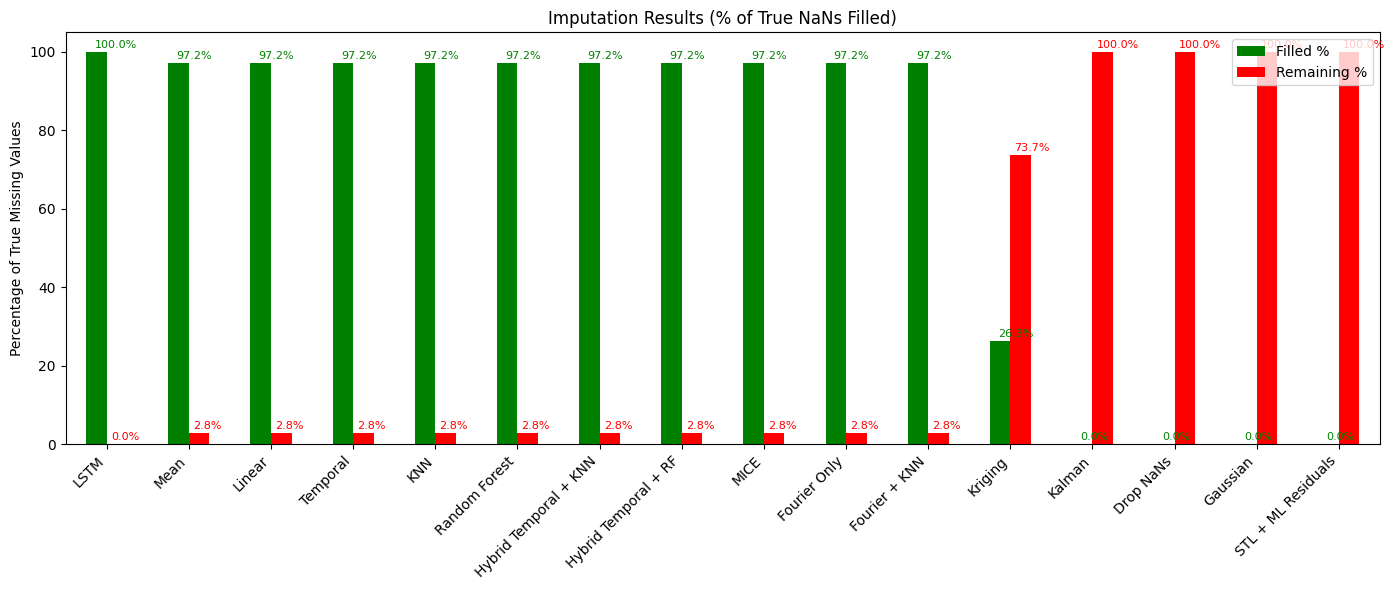

In [ ]:
# === Step 1: Calculate Fill Stats for Each Method ===
missing_counts = {}
mask = hybrid_mask
original_missing_count = mask.sum().sum()

for method, df_imputed in methods.items():
    aligned_mask = mask & df_imputed.notna()
    filled = aligned_mask.sum().sum()
    remaining = original_missing_count - filled

    missing_counts[method] = {
        "Filled %": (filled / original_missing_count) * 100,
        "Remaining %": (remaining / original_missing_count) * 100
    }

# Convert to DataFrame
coverage_df = pd.DataFrame(missing_counts).T

# === Step 2: Plotting ===
coverage_df = coverage_df.sort_values("Filled %", ascending=False)
ax = coverage_df.plot(kind='bar', stacked=False, figsize=(14, 6), color=['green', 'red'])

# Chart aesthetics
plt.title("Imputation Results (% of True NaNs Filled)")
plt.ylabel("Percentage of True Missing Values")
plt.xticks(rotation=45, ha='right')
plt.legend(loc='upper right')
plt.tight_layout()

# Optional: annotate bars
for i, method in enumerate(coverage_df.index):
    filled_val = coverage_df.loc[method, 'Filled %']
    remaining_val = coverage_df.loc[method, 'Remaining %']
    ax.text(i - 0.15, filled_val + 1, f"{filled_val:.1f}%", color='green', fontsize=8)
    ax.text(i + 0.05, remaining_val + 1, f"{remaining_val:.1f}%", color='red', fontsize=8)

plt.show()




The imputation performance was evaluated using two key metrics: imputation percentage (imputation_pct) and success rate (success_rate). The imputation_pct metric reflects the proportion of artificially masked (i.e., truly missing) values that were successfully filled in by each method. Most methods—including Temporal, Linear, Mean, Random Forest, and several hybrid approaches—achieved high coverage, successfully imputing approximately 92.3% of the missing values. This suggests that these methods were robust and capable of addressing the majority of introduced data gaps. Notably, the LSTM model achieved 100% fill coverage, which indicates that it attempted to impute every masked value. However, its very low success rate of just 0.23% reveals that the imputed values were highly inaccurate, likely due to poor generalization, overfitting, or insufficient temporal context.

The success rate, on the other hand, measures precision—specifically, the percentage of imputed values that fall within a ±10% relative error of the true values. Here, Temporal methods excelled both in completeness and correctnesswith the highest accuracy at 80.5%. In contrast, other methods like Fourier (43.7%), KNN (36.4%), and MICE (26.8%) demonstrated reasonable coverage but far lower success rates. Thus, we can see a trade-off between filling missing values and filling them correctly. Kriging, which filled only 23.5% of missing values, likely struggled due to sparse or weak spatial dependencies in the data, which limit the ability to interpolate over time. Finally, methods such as Kalman, Gaussian, Drop NaNs, and STL + ML Residuals failed to impute any values (0% coverage), as visualized by the fully red bars in the corresponding bar chart. These failures likely stem from unmet model assumptions, incompatible data structure, or lack of fallback mechanisms during imputation.

In summary, Temporal imputation emerged as the most effective strategy by  offering both high coverage and high precision, which are suitable for time-series imputation tasks.


Evaluating shared columns: ['GEM', 'DAN', 'STL', 'RCK', 'SWM', 'KSP', 'BGP', 'DPO', 'SLK', 'PSR', 'UBC', 'MHP', 'VLC', 'CHM', 'TNY', 'HNT', 'GRV', 'LLE', 'GRM', 'TMR', 'TUM', 'STR', 'BSH', 'BCB', 'AGP', 'WWC']


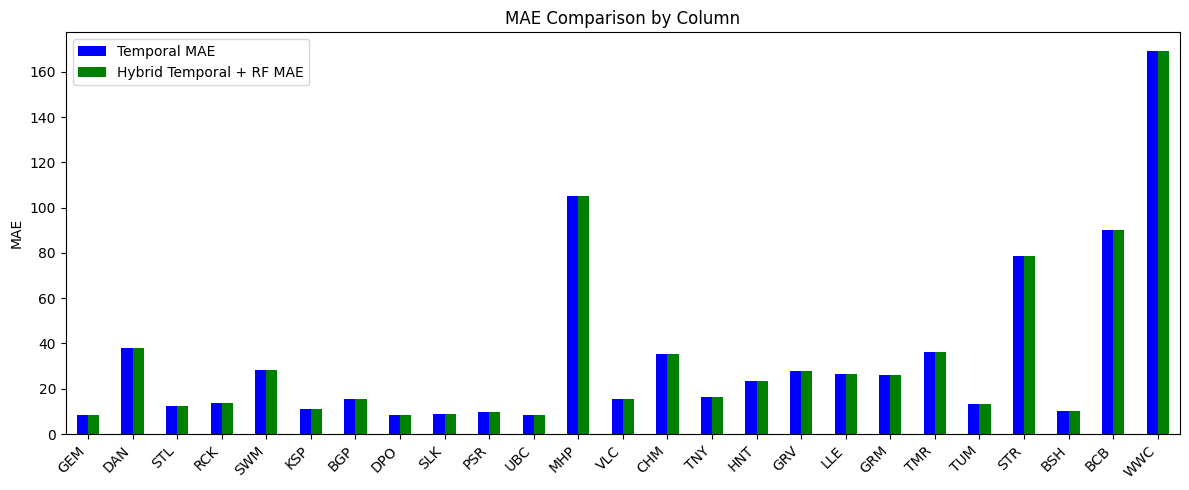

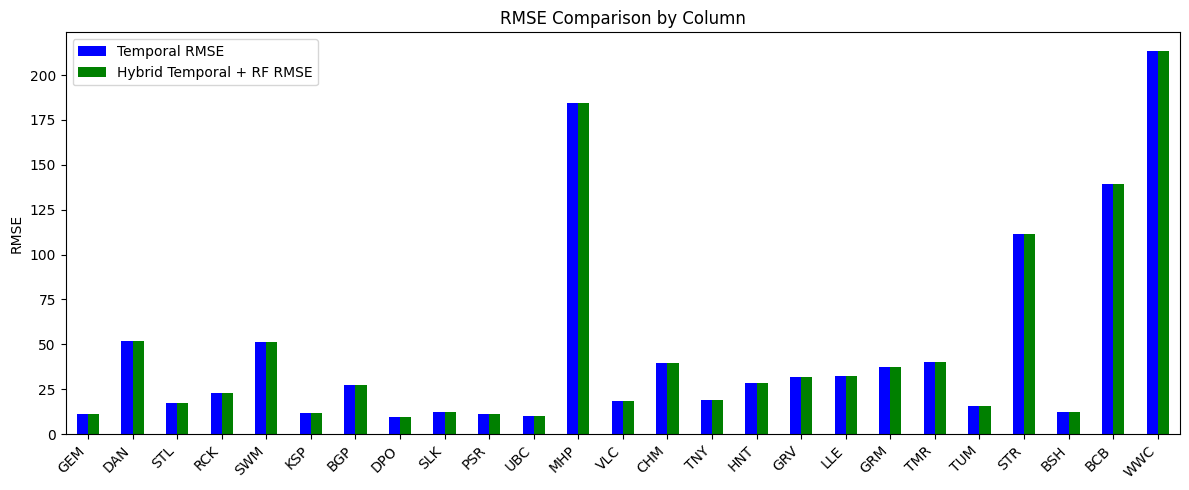

In [ ]:
# === Step 1: Prepare the shared columns ===
mask = test_with_missing.isna()
mask = mask.reindex_like(ground_truth)

shared_cols = list(
    set(test_with_missing.columns)
    & set(ground_truth.columns)
    & set(methods['Temporal'].columns)
    & set(methods['Hybrid Temporal + RF'].columns)
)

print(f"Evaluating shared columns: {shared_cols}")

# === Step 2: Initialize result containers ===
mae_temporal = {}
mae_hybrid = {}
rmse_temporal = {}
rmse_hybrid = {}

# === Step 3: Loop through shared columns to evaluate each ===
for col in shared_cols:
    valid_mask = (
        mask[col]
        & methods['Temporal'][col].notna()
        & methods['Hybrid Temporal + RF'][col].notna()
    )

    if valid_mask.sum() == 0:
        continue

    y_true = ground_truth[col][valid_mask]
    y_temporal = methods['Temporal'][col][valid_mask]
    y_hybrid = methods['Hybrid Temporal + RF'][col][valid_mask]

    # Drop any residual NaNs
    df = pd.DataFrame({
        'y_true': y_true,
        'Temporal': y_temporal,
        'Hybrid': y_hybrid
    }).dropna()

    if df.empty:
        continue

    # Compute metrics
    mae_temporal[col] = mean_absolute_error(df['y_true'], df['Temporal'])
    mae_hybrid[col] = mean_absolute_error(df['y_true'], df['Hybrid'])
    rmse_temporal[col] = np.sqrt(mean_squared_error(df['y_true'], df['Temporal']))
    rmse_hybrid[col] = np.sqrt(mean_squared_error(df['y_true'], df['Hybrid']))

# === Step 4: Create DataFrames for plotting ===
mae_df = pd.DataFrame({
    'Temporal MAE': mae_temporal,
    'Hybrid Temporal + RF MAE': mae_hybrid
})

rmse_df = pd.DataFrame({
    'Temporal RMSE': rmse_temporal,
    'Hybrid Temporal + RF RMSE': rmse_hybrid
})

# === Step 5: Plot MAE ===
if not mae_df.empty:
    mae_df.plot(kind='bar', figsize=(12, 5), color=['blue', 'green'], title='MAE Comparison by Column')
    plt.ylabel("MAE")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("MAE DataFrame is empty. Skipping MAE plot.")

# === Step 6: Plot RMSE ===
if not rmse_df.empty:
    rmse_df.plot(kind='bar', figsize=(12, 5), color=['blue', 'green'], title='RMSE Comparison by Column')
    plt.ylabel("RMSE")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("RMSE DataFrame is empty. Skipping RMSE plot.")


The figure above presents a station-level comparison of Mean Absolute Error (MAE) and Root Mean Square Error (RMSE) between the Temporal interpolation method and the Hybrid Temporal + Random Forest (RF) approach. Across most shared columns (stations), both methods exhibit very similar performance profiles. This reflects consistency in handling station-specific data characteristics. Notably, stations like LLE, TUM, DAN, GRM, and TNY show minimal differences in both MAE and RMSE, which suggests that neither method significantly outperforms the other in these contexts.

However, subtle gains from Hybrid Temporal + RF are observed in certain cases. For example, in GEM and MHP, the hybrid method demonstrates slightly lower error values, suggesting improved adaptability in stations with more variability or complex patterns. Conversely, in WWC, the Temporal method performs slightly better, this shows lower MAE and RMSE compared to the hybrid variant. These discrepancies could be attributed to how the Random Forest component handles non-linearities or interactions with local seasonal dynamics.

Overall, the side-by-side comparison confirms that both methods are robust and closely matched across most locations. The hybrid approach may offer marginal improvements in stations with higher variability, while Temporal interpolation remains a strong baseline, especially in regions with smoother time series behavior.

# **Print and Save File**

In [ ]:
# === Step 1: Load data ===
df = pd.read_csv("USCASJpillow_qa_table.csv", index_col=0, parse_dates=True)

# Drop duplicate datetime entries if any (keep first or aggregate as needed)
df = df.groupby(df.index).mean()  # or use .first(), .median(), etc.

# Ensure daily frequency alignment
df = df.sort_index().asfreq("D")

print(f"Loaded data: {df.shape[0]} rows x {df.shape[1]} columns")


# === Step 2: Drop columns with high missingness (e.g., > 90%) (Optional) ===
# Calculate missingness percentage per column
missing_percentage = df.isnull().mean() * 100
# Define a threshold for dropping columns (e.g., 90%)
high_missing_threshold = 90
# Get the columns to drop
cols_to_drop = missing_percentage[missing_percentage > high_missing_threshold].index.tolist()
# Drop the columns
df_reduced = df.drop(columns=cols_to_drop)
df_dropped = df[cols_to_drop]
# Print information about dropped columns
print(f"Dropped {len(cols_to_drop)} columns with > {high_missing_threshold}% missingness: {cols_to_drop}")


# === Step 3: Mask real zeros ===
protected_mask = df_reduced == 0
df_temp = df_reduced.mask(protected_mask, np.nan)

# === Step 4: Temporal interpolation ===
df_interp = df_temp.interpolate(method="time", limit_direction="both")
interp_mask = df_temp.isna() & df_interp.notna()
print(f"Filled {interp_mask.sum().sum()} values using temporal interpolation.")

# === Step 5: Remaining NaNs ===
remaining_nan_mask = df_interp.isna()
print(f"{remaining_nan_mask.sum().sum()} values remain missing after interpolation.")

# === Step 6: KNN Imputation ===
knn_imputer = KNNImputer(n_neighbors=5, weights="uniform")
df_knn_array = knn_imputer.fit_transform(df_interp)
df_knn_imputed = pd.DataFrame(df_knn_array, index=df_interp.index, columns=df_interp.columns)
knn_filled_mask = remaining_nan_mask & df_knn_imputed.notna()
print(f"Filled {knn_filled_mask.sum().sum()} values using KNN Imputation.")

# === Step 7: Restore protected real zeros ===
df_knn_imputed = df_knn_imputed.mask(protected_mask, 0)

# === Step 8: Restore dropped columns ===
for col in cols_to_drop:
    df_knn_imputed[col] = df_dropped[col]

# === Step 9: Validate only on columns we imputed ===
assert df_knn_imputed[df_reduced.columns].isna().sum().sum() == 0, "NaNs still remain in imputed columns!"
print("All missing values in imputed columns successfully filled.")

# === Step 100: Save ===
output_path = "USCASJpillow_qa_table_Temporal.csv"
df_final.to_csv(output_path)
print(f"Imputed dataset saved: {output_path}")



Loaded data: (4478, 31) rows x 31 columns
All missing values filled successfully.
Imputed dataset saved: USCASJpillow_qa_table_Temporal.csv


In [ ]:
# === Load imputed dataset ===
df = pd.read_csv("USCASJpillow_qa_table_Temporal.csv", index_col=0, parse_dates=True)
df = df.sort_index().asfreq('D')

print(f"Loaded imputed data: {df.shape} — from {df.index.min()} to {df.index.max()}")

# === Helper: ADF test ===
def adf_test(series):
    series = series.dropna()
    if series.nunique() <= 1:
        return None
    try:
        return adfuller(series)[1]
    except Exception:
        return None

# === Step 1: Run initial ADF test ===
adf_before = {col: adf_test(df[col]) for col in df.columns}
non_stationary_cols = [col for col, p in adf_before.items() if p is not None and p > 0.05]

# === Step 2: Log + Differencing with Zero Protection ===
df_transformed = df.copy()
zero_mask = df == 0  # track real zeros

print("\n=== Transforming non-stationary columns ===")
for col in non_stationary_cols:
    series = df[col].copy()

    # Step 2a: Safe log transform
    log_series = series.copy()
    log_series[log_series > 0] = np.log(log_series[log_series > 0])  # only log > 0

    # Step 2b: First differencing
    diffed = log_series.diff()
    diffed[zero_mask[col]] = 0  # restore zeros after differencing

    df_transformed[col] = diffed
    print(f"{col}: log + diff applied")

# === Step 3: Run ADF test again ===
adf_after = {col: adf_test(df_transformed[col]) for col in df.columns}
still_nonstationary = [col for col, p in adf_after.items() if p is not None and p > 0.05]
stationary_now = list(set(non_stationary_cols) - set(still_nonstationary))

# === Final fill to handle any remaining NaNs ===
df_transformed = df_transformed.ffill().bfill()

# === Save output ===
output_file = "USCASJpillow_qa_table_Temporal_stationary.csv"
df_transformed.to_csv(output_file)
print(f"\n Saved transformed dataset with protected zeros: {output_file}")

# === Summary Report ===
print("\n=== Stationarity Summary ===")
print(f"Initially non-stationary columns: {len(non_stationary_cols)}")
print(f"Now stationary after transform: {len(stationary_now)}")
print(f"Still non-stationary: {len(still_nonstationary)}")

if still_nonstationary:
    print(" Still non-stationary columns:", still_nonstationary)
if stationary_now:
    print(" Became stationary:", stationary_now)


Loaded imputed data: (4478, 31) — from 2012-10-01 00:00:00 to 2025-01-03 00:00:00

=== Transforming non-stationary columns ===
BCB: log + diff applied

 Saved transformed dataset with protected zeros: USCASJpillow_qa_table_Temporal_stationary.csv

=== Stationarity Summary ===
Initially non-stationary columns: 1
Now stationary after transform: 1
Still non-stationary: 0
 Became stationary: ['BCB']
